# Determining quantum bounds (different levels the NPA hierarchy)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ncpol2sdpa as ncp
from ncpol2sdpa import *
from scipy.optimize import minimize_scalar
from joblib import Parallel, delayed
import json

## The Tsirelson point case

### Level 1

In [2]:
# Define quantum operators
A_config = [2,2]
B_config = [2,2]

# Operators in problem
A = [Ai for Ai in ncp.generate_measurements(A_config, 'A')]
B = [Bj for Bj in ncp.generate_measurements(B_config, 'B')]

def get_subs():
    """
    Returns any substitution rules to use with ncpol2sdpa. E.g. projections and
    commutation relations.
    """
    subs = {}
    # Get Alice and Bob's projective measurement constraints
    subs.update(ncp.projective_measurement_constraints(A,B))

    return subs

subs = get_subs()             # substitutions used in ncpol2sdpa
moment_ineqs = []                      # moment inequalities
moment_eqs = []                        # moment equalities
op_eqs = []                            # operator equalities
op_ineqs = []                          # operator inequalities
extra_monos = []   # extra monomials

# Bounds on the parameters of sys
ops = ncp.flatten([A,B])        # Base monomials involved in problem

# Compute quantum value of Bell expression at (p1, p4) for a given Theta
def compute_beta(r0, r1):
    s = np.sqrt(2)

    beta_expr = 1./s - s*A[0][0] - s*B[0][0] + s*A[0][0]*B[0][0] + s*A[1][0]*B[0][0] + s*A[0][0]*B[1][0] - s*A[1][0]*B[1][0] + r0 - s*r0 + s*A[0][0]*r0 + s*A[1][0]*r0 - 2*B[0][0]*r0 + r1 + s*A[0][0]*r1 - s*A[1][0]*r1 - 2*B[1][0]*r1

    sdp = ncp.SdpRelaxation(ops, verbose=0, normalized=True, parallel=0)
    sdp.get_relaxation(
        level=1,
        equalities = op_eqs[:],
        inequalities = op_ineqs[:],
        momentequalities = moment_eqs[:],
        momentinequalities = moment_ineqs[:],
        objective=-beta_expr,
        substitutions = subs,
        extramonomials = extra_monos
    )
    sdp.solve(solver="mosek")
    return -sdp.dual

# Minimize r for fixed φ and Theta
def minimize_r(phi):
    def objective(r):
        if r < 0:
            return np.inf
        p1 = r * np.cos(phi)
        p4 = r * np.sin(phi)
        beta = compute_beta(p1, p4)
        return r if beta >= 1.00001 else np.inf

    res = minimize_scalar(objective, bounds=(0, 1), method='bounded')
    if res.success and np.isfinite(res.fun):
        r = res.x
        return r * np.cos(phi), r * np.sin(phi)
    else:
        return None

# Main routine
def compute_boundary(num_points=200, n_jobs=-1):
    phis = np.linspace(0, np.pi, num_points)
    boundary = Parallel(n_jobs=n_jobs)(
        delayed(minimize_r)(phi) for phi in phis
    )
    boundary = [pt for pt in boundary if pt is not None]
    return np.array(boundary)

In [3]:
get_subs()

{A0**2: A0,
 A1**2: A1,
 B0**2: B0,
 B1**2: B1,
 B0*A0: A0*B0,
 B1*A0: A0*B1,
 B0*A1: A1*B0,
 B1*A1: A1*B1}

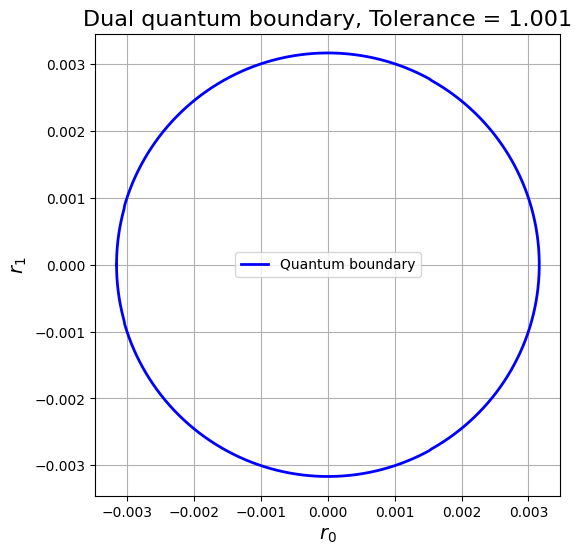

In [4]:
boundary = compute_boundary()

# Reflect the boundary across the p4-axis
reflected = boundary[boundary[:, 1] != 0] * np.array([1, -1])
full_boundary = np.vstack([boundary, reflected])

# Sort the points by polar angle to ensure a smooth curve
angles = np.arctan2(full_boundary[:, 1], full_boundary[:, 0])
sorted_idx = np.argsort(angles)
full_boundary = full_boundary[sorted_idx]

# Plotting
plt.figure(figsize=(6, 6))
plt.plot(full_boundary[:, 0], full_boundary[:, 1], 'b-', lw=2, label="Quantum boundary")
plt.xlabel(r"$r_0$", fontsize=14)
plt.ylabel(r"$r_1$", fontsize=14)
plt.title("Dual quantum boundary, Tolerance = 1.001", fontsize=16)
plt.grid(True)
plt.axis("equal")
plt.legend()
plt.show()

### Mixed level 1 ($T_{AB} = \mathcal{T}_{1 + A + B + AB}$)

In [5]:
# Define quantum operators
A_config = [2,2]
B_config = [2,2]

# Operators in problem
A = [Ai for Ai in ncp.generate_measurements(A_config, 'A')]
B = [Bj for Bj in ncp.generate_measurements(B_config, 'B')]

def get_extra_monomials():
    """
    Returns additional monomials to add to sdp relaxation.
    """

    monos = []

    Aflat = ncp.flatten(A)
    Bflat = ncp.flatten(B)

    #AB
    for a in Aflat:
        for b in Bflat:
            monos += [a*b]
    
    
    return monos[:]

def get_subs():
    """
    Returns any substitution rules to use with ncpol2sdpa. E.g. projections and
    commutation relations.
    """
    subs = {}
    # Get Alice and Bob's projective measurement constraints
    subs.update(ncp.projective_measurement_constraints(A,B))

    return subs

subs = get_subs()             # substitutions used in ncpol2sdpa
moment_ineqs = []                      # moment inequalities
moment_eqs = []                        # moment equalities
op_eqs = []                            # operator equalities
op_ineqs = []                          # operator inequalities
extra_monos = get_extra_monomials()   # extra monomials

# Bounds on the parameters of sys
ops = ncp.flatten([A,B])        # Base monomials involved in problem

# Compute quantum value of Bell expression at (p1, p4) for a given Theta
def compute_beta(r0, r1):
    s = np.sqrt(2)

    beta_expr = 1./s - s*A[0][0] - s*B[0][0] + s*A[0][0]*B[0][0] + s*A[1][0]*B[0][0] + s*A[0][0]*B[1][0] - s*A[1][0]*B[1][0] + r0 - s*r0 + s*A[0][0]*r0 + s*A[1][0]*r0 - 2*B[0][0]*r0 + r1 + s*A[0][0]*r1 - s*A[1][0]*r1 - 2*B[1][0]*r1

    sdp = ncp.SdpRelaxation(ops, verbose=0, normalized=True, parallel=0)
    sdp.get_relaxation(
        level=1,
        equalities = op_eqs[:],
        inequalities = op_ineqs[:],
        momentequalities = moment_eqs[:],
        momentinequalities = moment_ineqs[:],
        objective=-beta_expr,
        substitutions = subs,
        extramonomials = extra_monos
    )
    sdp.solve(solver="mosek")
    return -sdp.dual

# Minimize r for fixed φ and Theta
def minimize_r(phi):
    def objective(r):
        if r < 0:
            return np.inf
        p1 = r * np.cos(phi)
        p4 = r * np.sin(phi)
        beta = compute_beta(p1, p4)
        return r if beta >= 1.00001 else np.inf

    res = minimize_scalar(objective, bounds=(0, 1), method='bounded')
    if res.success and np.isfinite(res.fun):
        r = res.x
        return r * np.cos(phi), r * np.sin(phi)
    else:
        return None

# Main routine
def compute_boundary(num_points=200, n_jobs=-1):
    phis = np.linspace(0, np.pi, num_points)
    boundary = Parallel(n_jobs=n_jobs)(
        delayed(minimize_r)(phi) for phi in phis
    )
    boundary = [pt for pt in boundary if pt is not None]
    return np.array(boundary)

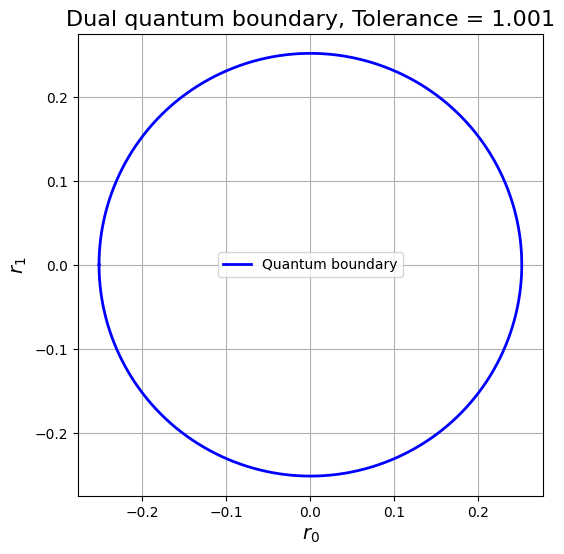

In [6]:
boundary = compute_boundary()

# Reflect the boundary across the p4-axis
reflected = boundary[boundary[:, 1] != 0] * np.array([1, -1])
full_boundary = np.vstack([boundary, reflected])

# Sort the points by polar angle to ensure a smooth curve
angles = np.arctan2(full_boundary[:, 1], full_boundary[:, 0])
sorted_idx = np.argsort(angles)
full_boundary = full_boundary[sorted_idx]

# Plotting
plt.figure(figsize=(6, 6))
plt.plot(full_boundary[:, 0], full_boundary[:, 1], 'b-', lw=2, label="Quantum boundary")
plt.xlabel(r"$r_0$", fontsize=14)
plt.ylabel(r"$r_1$", fontsize=14)
plt.title("Dual quantum boundary, Tolerance = 1.001", fontsize=16)
plt.grid(True)
plt.axis("equal")
plt.legend()
plt.show()

### Level 2

In [7]:
# Define quantum operators
A_config = [2,2]
B_config = [2,2]

# Operators in problem
A = [Ai for Ai in ncp.generate_measurements(A_config, 'A')]
B = [Bj for Bj in ncp.generate_measurements(B_config, 'B')]

def get_subs():
    """
    Returns any substitution rules to use with ncpol2sdpa. E.g. projections and
    commutation relations.
    """
    subs = {}
    # Get Alice and Bob's projective measurement constraints
    subs.update(ncp.projective_measurement_constraints(A,B))

    return subs

subs = get_subs()             # substitutions used in ncpol2sdpa
moment_ineqs = []                      # moment inequalities
moment_eqs = []                        # moment equalities
op_eqs = []                            # operator equalities
op_ineqs = []                          # operator inequalities
extra_monos = []   # extra monomials

# Bounds on the parameters of sys
ops = ncp.flatten([A,B])        # Base monomials involved in problem

# Compute quantum value of Bell expression at (p1, p4) for a given Theta
def compute_beta(r0, r1):
    s = np.sqrt(2)

    beta_expr = 1./s - s*A[0][0] - s*B[0][0] + s*A[0][0]*B[0][0] + s*A[1][0]*B[0][0] + s*A[0][0]*B[1][0] - s*A[1][0]*B[1][0] + r0 - s*r0 + s*A[0][0]*r0 + s*A[1][0]*r0 - 2*B[0][0]*r0 + r1 + s*A[0][0]*r1 - s*A[1][0]*r1 - 2*B[1][0]*r1

    sdp = ncp.SdpRelaxation(ops, verbose=0, normalized=True, parallel=0)
    sdp.get_relaxation(
        level=2,
        equalities = op_eqs[:],
        inequalities = op_ineqs[:],
        momentequalities = moment_eqs[:],
        momentinequalities = moment_ineqs[:],
        objective=-beta_expr,
        substitutions = subs,
        extramonomials = extra_monos
    )
    sdp.solve(solver="mosek")
    return -sdp.dual

# Minimize r for fixed φ and Theta
def minimize_r(phi):
    def objective(r):
        if r < 0:
            return np.inf
        p1 = r * np.cos(phi)
        p4 = r * np.sin(phi)
        beta = compute_beta(p1, p4)
        return r if beta >= 1.00001 else np.inf

    res = minimize_scalar(objective, bounds=(0, 1), method='bounded')
    if res.success and np.isfinite(res.fun):
        r = res.x
        return r * np.cos(phi), r * np.sin(phi)
    else:
        return None

# Main routine
def compute_boundary(num_points=200, n_jobs=-1):
    phis = np.linspace(0, np.pi, num_points)
    boundary = Parallel(n_jobs=n_jobs)(
        delayed(minimize_r)(phi) for phi in phis
    )
    boundary = [pt for pt in boundary if pt is not None]
    return np.array(boundary)

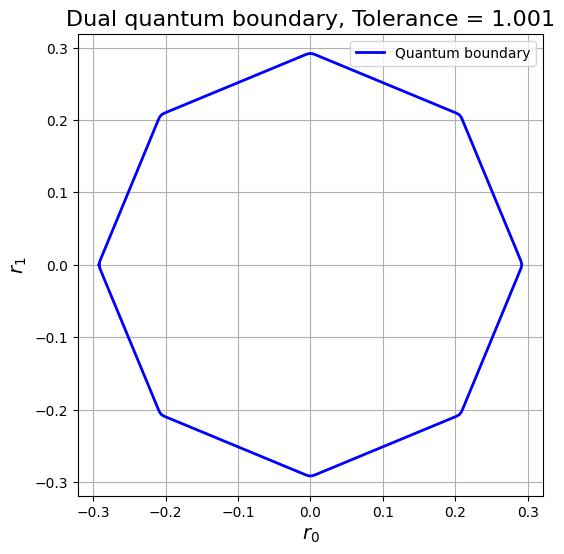

In [8]:
boundary = compute_boundary()

# Reflect the boundary across the p4-axis
reflected = boundary[boundary[:, 1] != 0] * np.array([1, -1])
full_boundary = np.vstack([boundary, reflected])

# Sort the points by polar angle to ensure a smooth curve
angles = np.arctan2(full_boundary[:, 1], full_boundary[:, 0])
sorted_idx = np.argsort(angles)
full_boundary = full_boundary[sorted_idx]

# Plotting
plt.figure(figsize=(6, 6))
plt.plot(full_boundary[:, 0], full_boundary[:, 1], 'b-', lw=2, label="Quantum boundary")
plt.xlabel(r"$r_0$", fontsize=14)
plt.ylabel(r"$r_1$", fontsize=14)
plt.title("Dual quantum boundary, Tolerance = 1.001", fontsize=16)
plt.grid(True)
plt.axis("equal")
plt.legend()
plt.show()

# Different values of $\theta$

## Level 1

In [9]:
# Define quantum operators
A_config = [2,2]
B_config = [2,2]

# Operators in problem
A = [Ai for Ai in ncp.generate_measurements(A_config, 'A')]
B = [Bj for Bj in ncp.generate_measurements(B_config, 'B')]

def get_subs():
    """
    Returns any substitution rules to use with ncpol2sdpa. E.g. projections and
    commutation relations.
    """
    subs = {}
    # Get Alice and Bob's projective measurement constraints
    subs.update(ncp.projective_measurement_constraints(A,B))

    return subs

subs = get_subs()             # substitutions used in ncpol2sdpa
moment_ineqs = []                      # moment inequalities
moment_eqs = []                        # moment equalities
op_eqs = []                            # operator equalities
op_ineqs = []                          # operator inequalities
extra_monos = []   # extra monomials

# Bounds on the parameters of sys
ops = ncp.flatten([A,B])        # Base monomials involved in problem

# Compute quantum value of Bell expression at (p1, p4) for a given Theta
def compute_beta(p1, p4, Theta):
    s = np.sqrt(2)

    beta_expr = 1/4*p4*(4*(-2 + 4*A[1][0]) - 8*s*(-1 + 2*A[1][0])*(-1 + B[0][0] + B[1][0])*np.cos(2*Theta) + 8*s*(-B[0][0] + B[1][0])*np.sin(2*Theta)) +  1/4*(4*s - 8*s*A[0][0] - 4*s*B[0][0] + 8*s*A[0][0]*B[0][0] - 4*s*B[1][0] + 8*s*A[0][0]*B[1][0] + s*(-1 + 2*A[1][0])*(B[0][0] - B[1][0])*1/np.tan(Theta) - s*(-1 + A[0][0])*(-1 + B[0][0] + B[1][0])*1/(np.sin(Theta))**2 - s*A[0][0]*(-1 + B[0][0] + B[1][0])*1/(np.cos(Theta))**2 + s*(-1 + 2*A[1][0])*(B[0][0] - B[1][0])*np.tan(Theta)) + 1/4*p1*(2*(-2 + s) + 8*A[0][0] - 2*s*B[0][0] - 2*s*B[1][0] - s*(-1 + 2*A[1][0])*(B[0][0] - B[1][0])*1/np.tan(Theta) + s*(-1 + A[0][0])*(-1 + B[0][0] + B[1][0])*1/(np.sin(Theta))**2 - s*A[0][0]*(-1 + B[0][0] + B[1][0])*1/(np.cos(Theta))**2 + s*(-1 + 2*A[1][0])*(B[0][0] - B[1][0])*np.tan(Theta))

    sdp = ncp.SdpRelaxation(ops, verbose=0, normalized=True, parallel=0)
    sdp.get_relaxation(
        level=1,
        equalities = op_eqs[:],
        inequalities = op_ineqs[:],
        momentequalities = moment_eqs[:],
        momentinequalities = moment_ineqs[:],
        objective=-beta_expr,
        substitutions = subs,
        extramonomials = extra_monos
    )
    sdp.solve(solver="mosek")
    return -sdp.dual

# Minimize r for fixed φ and Theta
def minimize_r(phi, Theta):
    def objective(r):
        if r < 0:
            return np.inf
        p1 = r * np.cos(phi)
        p4 = r * np.sin(phi)
        beta = compute_beta(p1, p4, Theta)
        return r if beta >= 1.00001 else np.inf

    res = minimize_scalar(objective, bounds=(0, 1), method='bounded')
    if res.success and np.isfinite(res.fun):
        r = res.x
        return r * np.cos(phi), r * np.sin(phi)
    else:
        return None

# Main routine
def compute_boundary(Theta, num_points=200, n_jobs=-1):
    phis = np.linspace(0, np.pi, num_points)
    boundary = Parallel(n_jobs=n_jobs)(
        delayed(minimize_r)(phi, Theta) for phi in phis
    )
    boundary = [pt for pt in boundary if pt is not None]
    return np.array(boundary)

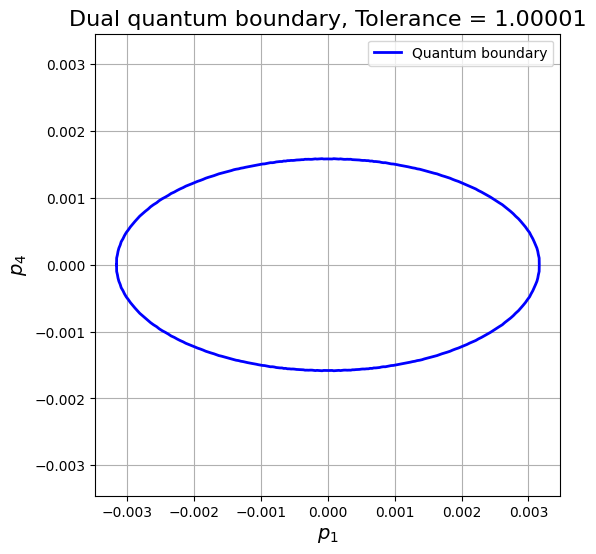

In [10]:
Theta_val = np.pi / 4
boundary = compute_boundary(Theta_val)

# Reflect the boundary across the p4-axis
reflected = boundary[boundary[:, 1] != 0] * np.array([1, -1])
full_boundary = np.vstack([boundary, reflected])

# Sort the points by polar angle to ensure a smooth curve
angles = np.arctan2(full_boundary[:, 1], full_boundary[:, 0])
sorted_idx = np.argsort(angles)
full_boundary = full_boundary[sorted_idx]

# Plotting
plt.figure(figsize=(6, 6))
plt.plot(full_boundary[:, 0], full_boundary[:, 1], 'b-', lw=2, label="Quantum boundary")
plt.xlabel(r"$p_1$", fontsize=14)
plt.ylabel(r"$p_4$", fontsize=14)
plt.title("Dual quantum boundary, Tolerance = 1.00001", fontsize=16)
plt.grid(True)
plt.axis("equal")
plt.legend()
plt.show()

## Mixed level 1 ($T_{AB} = \mathcal{T}_{1 + A + B + AB}$)

In [11]:
# Define quantum operators
A_config = [2,2]
B_config = [2,2]

# Operators in problem
A = [Ai for Ai in ncp.generate_measurements(A_config, 'A')]
B = [Bj for Bj in ncp.generate_measurements(B_config, 'B')]

def get_extra_monomials():
    """
    Returns additional monomials to add to sdp relaxation.
    """

    monos = []

    Aflat = ncp.flatten(A)
    Bflat = ncp.flatten(B)

    #AB
    for a in Aflat:
        for b in Bflat:
            monos += [a*b]
    
    
    return monos[:]

def get_subs():
    """
    Returns any substitution rules to use with ncpol2sdpa. E.g. projections and
    commutation relations.
    """
    subs = {}
    # Get Alice and Bob's projective measurement constraints
    subs.update(ncp.projective_measurement_constraints(A,B))

    return subs

subs = get_subs()             # substitutions used in ncpol2sdpa
moment_ineqs = []                      # moment inequalities
moment_eqs = []                        # moment equalities
op_eqs = []                            # operator equalities
op_ineqs = []                          # operator inequalities
extra_monos = get_extra_monomials()   # extra monomials

# Bounds on the parameters of sys
ops = ncp.flatten([A,B])        # Base monomials involved in problem

# Compute quantum value of Bell expression at (p1, p4) for a given Theta
def compute_beta(p1, p4, Theta):
    s = np.sqrt(2)

    beta_expr = 1/4*p4*(4*(-2 + 4*A[1][0]) - 8*s*(-1 + 2*A[1][0])*(-1 + B[0][0] + B[1][0])*np.cos(2*Theta) + 8*s*(-B[0][0] + B[1][0])*np.sin(2*Theta)) +  1/4*(4*s - 8*s*A[0][0] - 4*s*B[0][0] + 8*s*A[0][0]*B[0][0] - 4*s*B[1][0] + 8*s*A[0][0]*B[1][0] + s*(-1 + 2*A[1][0])*(B[0][0] - B[1][0])*1/np.tan(Theta) - s*(-1 + A[0][0])*(-1 + B[0][0] + B[1][0])*1/(np.sin(Theta))**2 - s*A[0][0]*(-1 + B[0][0] + B[1][0])*1/(np.cos(Theta))**2 + s*(-1 + 2*A[1][0])*(B[0][0] - B[1][0])*np.tan(Theta)) + 1/4*p1*(2*(-2 + s) + 8*A[0][0] - 2*s*B[0][0] - 2*s*B[1][0] - s*(-1 + 2*A[1][0])*(B[0][0] - B[1][0])*1/np.tan(Theta) + s*(-1 + A[0][0])*(-1 + B[0][0] + B[1][0])*1/(np.sin(Theta))**2 - s*A[0][0]*(-1 + B[0][0] + B[1][0])*1/(np.cos(Theta))**2 + s*(-1 + 2*A[1][0])*(B[0][0] - B[1][0])*np.tan(Theta))

    sdp = ncp.SdpRelaxation(ops, verbose=0, normalized=True, parallel=0)
    sdp.get_relaxation(
        level=1,
        equalities = op_eqs[:],
        inequalities = op_ineqs[:],
        momentequalities = moment_eqs[:],
        momentinequalities = moment_ineqs[:],
        objective=-beta_expr,
        substitutions = subs,
        extramonomials = extra_monos
    )
    sdp.solve(solver="mosek")
    return -sdp.dual

# Minimize r for fixed φ and Theta
def minimize_r(phi, Theta):
    def objective(r):
        if r < 0:
            return np.inf
        p1 = r * np.cos(phi)
        p4 = r * np.sin(phi)
        beta = compute_beta(p1, p4, Theta)
        return r if beta >= 1.00001 else np.inf

    res = minimize_scalar(objective, bounds=(0, 1), method='bounded')
    if res.success and np.isfinite(res.fun):
        r = res.x
        return r * np.cos(phi), r * np.sin(phi)
    else:
        return None

# Main routine
def compute_boundary(Theta, num_points=200, n_jobs=-1):
    phis = np.linspace(0, np.pi, num_points)
    boundary = Parallel(n_jobs=n_jobs)(
        delayed(minimize_r)(phi, Theta) for phi in phis
    )
    boundary = [pt for pt in boundary if pt is not None]
    return np.array(boundary)

### $\theta = \pi / 4$

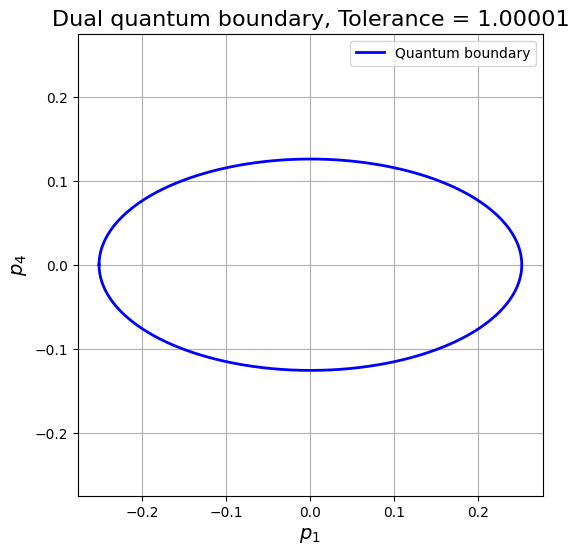

In [12]:
Theta_val = np.pi / 4
boundary = compute_boundary(Theta_val)

# Reflect the boundary across the p4-axis
reflected = boundary[boundary[:, 1] != 0] * np.array([1, -1])
full_boundary = np.vstack([boundary, reflected])

# Sort the points by polar angle to ensure a smooth curve
angles = np.arctan2(full_boundary[:, 1], full_boundary[:, 0])
sorted_idx = np.argsort(angles)
full_boundary = full_boundary[sorted_idx]

# Plotting
plt.figure(figsize=(6, 6))
plt.plot(full_boundary[:, 0], full_boundary[:, 1], 'b-', lw=2, label="Quantum boundary")
plt.xlabel(r"$p_1$", fontsize=14)
plt.ylabel(r"$p_4$", fontsize=14)
plt.title("Dual quantum boundary, Tolerance = 1.00001", fontsize=16)
plt.grid(True)
plt.axis("equal")
plt.legend()
plt.show()

## Level 2

In [13]:
# Define quantum operators
A_config = [2,2]
B_config = [2,2]

# Operators in problem
A = [Ai for Ai in ncp.generate_measurements(A_config, 'A')]
B = [Bj for Bj in ncp.generate_measurements(B_config, 'B')]

def get_subs():
    """
    Returns any substitution rules to use with ncpol2sdpa. E.g. projections and
    commutation relations.
    """
    subs = {}
    # Get Alice and Bob's projective measurement constraints
    subs.update(ncp.projective_measurement_constraints(A,B))

    return subs

subs = get_subs()             # substitutions used in ncpol2sdpa
moment_ineqs = []                      # moment inequalities
moment_eqs = []                        # moment equalities
op_eqs = []                            # operator equalities
op_ineqs = []                          # operator inequalities
extra_monos = []   # extra monomials

# Bounds on the parameters of sys
ops = ncp.flatten([A,B])        # Base monomials involved in problem

# Compute quantum value of Bell expression at (p1, p4) for a given Theta
def compute_beta(p1, p4, Theta):
    s = np.sqrt(2)

    beta_expr = 1/4*p4*(4*(-2 + 4*A[1][0]) - 8*s*(-1 + 2*A[1][0])*(-1 + B[0][0] + B[1][0])*np.cos(2*Theta) + 8*s*(-B[0][0] + B[1][0])*np.sin(2*Theta)) +  1/4*(4*s - 8*s*A[0][0] - 4*s*B[0][0] + 8*s*A[0][0]*B[0][0] - 4*s*B[1][0] + 8*s*A[0][0]*B[1][0] + s*(-1 + 2*A[1][0])*(B[0][0] - B[1][0])*1/np.tan(Theta) - s*(-1 + A[0][0])*(-1 + B[0][0] + B[1][0])*1/(np.sin(Theta))**2 - s*A[0][0]*(-1 + B[0][0] + B[1][0])*1/(np.cos(Theta))**2 + s*(-1 + 2*A[1][0])*(B[0][0] - B[1][0])*np.tan(Theta)) + 1/4*p1*(2*(-2 + s) + 8*A[0][0] - 2*s*B[0][0] - 2*s*B[1][0] - s*(-1 + 2*A[1][0])*(B[0][0] - B[1][0])*1/np.tan(Theta) + s*(-1 + A[0][0])*(-1 + B[0][0] + B[1][0])*1/(np.sin(Theta))**2 - s*A[0][0]*(-1 + B[0][0] + B[1][0])*1/(np.cos(Theta))**2 + s*(-1 + 2*A[1][0])*(B[0][0] - B[1][0])*np.tan(Theta))

    sdp = ncp.SdpRelaxation(ops, verbose=0, normalized=True, parallel=0)
    sdp.get_relaxation(
        level=2,
        equalities = op_eqs[:],
        inequalities = op_ineqs[:],
        momentequalities = moment_eqs[:],
        momentinequalities = moment_ineqs[:],
        objective=-beta_expr,
        substitutions = subs,
        extramonomials = extra_monos
    )
    sdp.solve(solver="mosek")
    return -sdp.dual

# Minimize r for fixed φ and Theta
def minimize_r(phi, Theta):
    def objective(r):
        if r < 0:
            return np.inf
        p1 = r * np.cos(phi)
        p4 = r * np.sin(phi)
        beta = compute_beta(p1, p4, Theta)
        return r if beta >= 1.00001 else np.inf

    res = minimize_scalar(objective, bounds=(0, 1), method='bounded')
    if res.success and np.isfinite(res.fun):
        r = res.x
        return r * np.cos(phi), r * np.sin(phi)
    else:
        return None

# Main routine
def compute_boundary(Theta, num_points=200, n_jobs=-1):
    phis = np.linspace(0, np.pi, num_points)
    boundary = Parallel(n_jobs=n_jobs)(
        delayed(minimize_r)(phi, Theta) for phi in phis
    )
    boundary = [pt for pt in boundary if pt is not None]
    return np.array(boundary)

### $\theta = \pi / 4$

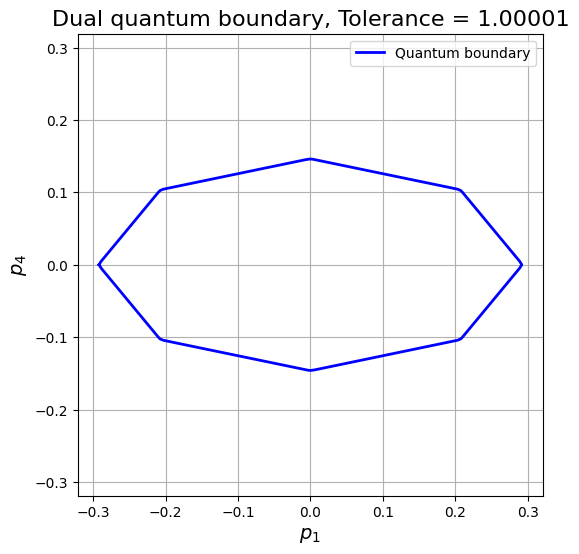

In [14]:
Theta_val = np.pi / 4
boundary = compute_boundary(Theta_val)

# Reflect the boundary across the p4-axis
reflected = boundary[boundary[:, 1] != 0] * np.array([1, -1])
full_boundary = np.vstack([boundary, reflected])

# Sort the points by polar angle to ensure a smooth curve
angles = np.arctan2(full_boundary[:, 1], full_boundary[:, 0])
sorted_idx = np.argsort(angles)
full_boundary = full_boundary[sorted_idx]

# Plotting
plt.figure(figsize=(6, 6))
plt.plot(full_boundary[:, 0], full_boundary[:, 1], 'b-', lw=2, label="Quantum boundary")
plt.xlabel(r"$p_1$", fontsize=14)
plt.ylabel(r"$p_4$", fontsize=14)
plt.title("Dual quantum boundary, Tolerance = 1.00001", fontsize=16)
plt.grid(True)
plt.axis("equal")
plt.legend()
plt.show()

### $\theta = \pi/8 + \pi/64$

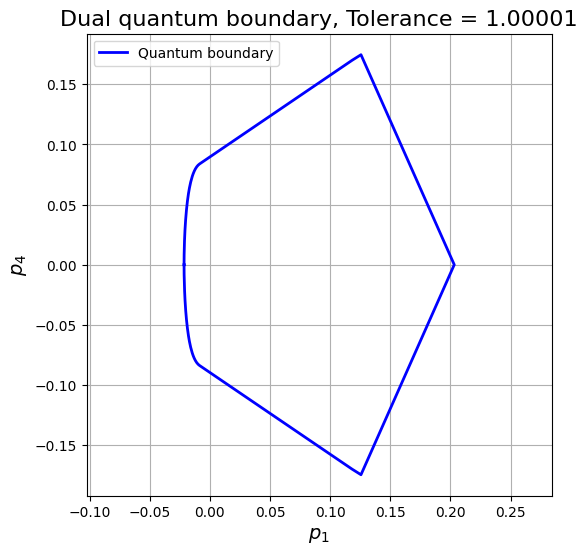

In [15]:
Theta_val = np.pi / 8 + np.pi/64
boundary = compute_boundary(Theta_val)

# Reflect the boundary across the p4-axis
reflected = boundary[boundary[:, 1] != 0] * np.array([1, -1])
full_boundary = np.vstack([boundary, reflected])

# Sort the points by polar angle to ensure a smooth curve
angles = np.arctan2(full_boundary[:, 1], full_boundary[:, 0])
sorted_idx = np.argsort(angles)
full_boundary = full_boundary[sorted_idx]

# Plotting
plt.figure(figsize=(6, 6))
plt.plot(full_boundary[:, 0], full_boundary[:, 1], 'b-', lw=2, label="Quantum boundary")
plt.xlabel(r"$p_1$", fontsize=14)
plt.ylabel(r"$p_4$", fontsize=14)
plt.title("Dual quantum boundary, Tolerance = 1.00001", fontsize=16)
plt.grid(True)
plt.axis("equal")
plt.legend()
plt.show()

### $\theta = \pi/4 - \pi/32$

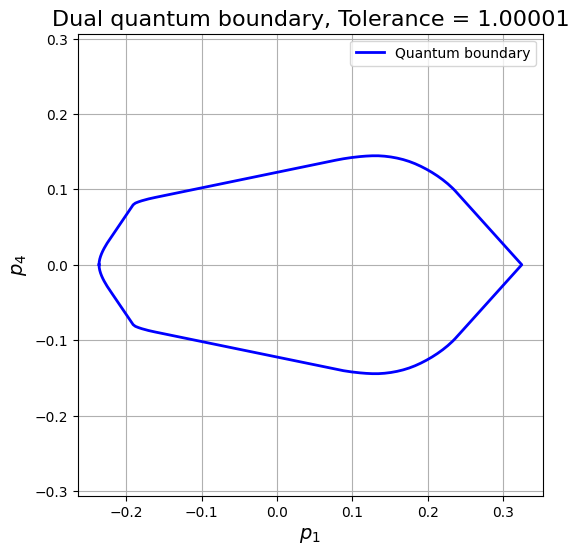

In [42]:
Theta_val = np.pi / 4 - np.pi / 32
boundary = compute_boundary(Theta_val)

# Reflect the boundary across the p4-axis
reflected = boundary[boundary[:, 1] != 0] * np.array([1, -1])
full_boundary = np.vstack([boundary, reflected])

# Sort the points by polar angle to ensure a smooth curve
angles = np.arctan2(full_boundary[:, 1], full_boundary[:, 0])
sorted_idx = np.argsort(angles)
full_boundary = full_boundary[sorted_idx]

# Plotting
plt.figure(figsize=(6, 6))
plt.plot(full_boundary[:, 0], full_boundary[:, 1], 'b-', lw=2, label="Quantum boundary")
plt.xlabel(r"$p_1$", fontsize=14)
plt.ylabel(r"$p_4$", fontsize=14)
plt.title("Dual quantum boundary, Tolerance = 1.00001", fontsize=16)
plt.grid(True)
plt.axis("equal")
plt.legend()
plt.show()

### $\theta = \pi/4 - \pi/64$

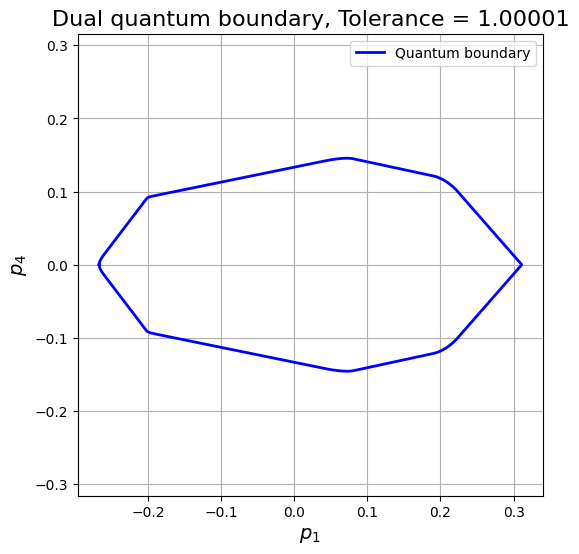

In [43]:
Theta_val = np.pi / 4 - np.pi/(64)
boundary = compute_boundary(Theta_val)

# Reflect the boundary across the p4-axis
reflected = boundary[boundary[:, 1] != 0] * np.array([1, -1])
full_boundary = np.vstack([boundary, reflected])

# Sort the points by polar angle to ensure a smooth curve
angles = np.arctan2(full_boundary[:, 1], full_boundary[:, 0])
sorted_idx = np.argsort(angles)
full_boundary = full_boundary[sorted_idx]

# Plotting
plt.figure(figsize=(6, 6))
plt.plot(full_boundary[:, 0], full_boundary[:, 1], 'b-', lw=2, label="Quantum boundary")
plt.xlabel(r"$p_1$", fontsize=14)
plt.ylabel(r"$p_4$", fontsize=14)
plt.title("Dual quantum boundary, Tolerance = 1.00001", fontsize=16)
plt.grid(True)
plt.axis("equal")
plt.legend()
plt.show()

## Mixed level 2 ($T_{ABB} = \mathcal{T}_{1+A+B+AB+ABB'}$)

In [16]:
# Define quantum operators
A_config = [2,2]
B_config = [2,2]

# Operators in problem
A = [Ai for Ai in ncp.generate_measurements(A_config, 'A')]
B = [Bj for Bj in ncp.generate_measurements(B_config, 'B')]

def get_extra_monomials():
    """
    Returns additional monomials to add to sdp relaxation.
    """

    monos = []

    Aflat = ncp.flatten(A)
    Bflat = ncp.flatten(B)

    # ABB
    for a in Aflat:
        for b in Bflat:
            for b2 in Bflat:
                monos += [a*b*b2]

    #AB
    for a in Aflat:
        for b in Bflat:
            monos += [a*b]
    
    
    return monos[:]

def get_subs():
    """
    Returns any substitution rules to use with ncpol2sdpa. E.g. projections and
    commutation relations.
    """
    subs = {}
    # Get Alice and Bob's projective measurement constraints
    subs.update(ncp.projective_measurement_constraints(A,B))

    return subs

subs = get_subs()             # substitutions used in ncpol2sdpa
moment_ineqs = []                      # moment inequalities
moment_eqs = []                        # moment equalities
op_eqs = []                            # operator equalities
op_ineqs = []                          # operator inequalities
extra_monos = get_extra_monomials()   # extra monomials

# Bounds on the parameters of sys
ops = ncp.flatten([A,B])        # Base monomials involved in problem

# Compute quantum value of Bell expression at (p1, p4) for a given Theta
def compute_beta(p1, p4, Theta):
    s = np.sqrt(2)

    beta_expr = 1/4*p4*(4*(-2 + 4*A[1][0]) - 8*s*(-1 + 2*A[1][0])*(-1 + B[0][0] + B[1][0])*np.cos(2*Theta) + 8*s*(-B[0][0] + B[1][0])*np.sin(2*Theta)) +  1/4*(4*s - 8*s*A[0][0] - 4*s*B[0][0] + 8*s*A[0][0]*B[0][0] - 4*s*B[1][0] + 8*s*A[0][0]*B[1][0] + s*(-1 + 2*A[1][0])*(B[0][0] - B[1][0])*1/np.tan(Theta) - s*(-1 + A[0][0])*(-1 + B[0][0] + B[1][0])*1/(np.sin(Theta))**2 - s*A[0][0]*(-1 + B[0][0] + B[1][0])*1/(np.cos(Theta))**2 + s*(-1 + 2*A[1][0])*(B[0][0] - B[1][0])*np.tan(Theta)) + 1/4*p1*(2*(-2 + s) + 8*A[0][0] - 2*s*B[0][0] - 2*s*B[1][0] - s*(-1 + 2*A[1][0])*(B[0][0] - B[1][0])*1/np.tan(Theta) + s*(-1 + A[0][0])*(-1 + B[0][0] + B[1][0])*1/(np.sin(Theta))**2 - s*A[0][0]*(-1 + B[0][0] + B[1][0])*1/(np.cos(Theta))**2 + s*(-1 + 2*A[1][0])*(B[0][0] - B[1][0])*np.tan(Theta))

    sdp = ncp.SdpRelaxation(ops, verbose=0, normalized=True, parallel=0)
    sdp.get_relaxation(
        level=2,
        equalities = op_eqs[:],
        inequalities = op_ineqs[:],
        momentequalities = moment_eqs[:],
        momentinequalities = moment_ineqs[:],
        objective=-beta_expr,
        substitutions = subs,
        extramonomials = extra_monos
    )
    sdp.solve(solver="mosek")
    return -sdp.dual

# Minimize r for fixed φ and Theta
def minimize_r(phi, Theta):
    def objective(r):
        if r < 0:
            return np.inf
        p1 = r * np.cos(phi)
        p4 = r * np.sin(phi)
        beta = compute_beta(p1, p4, Theta)
        return r if beta >= 1.00001 else np.inf

    res = minimize_scalar(objective, bounds=(0, 1), method='bounded')
    if res.success and np.isfinite(res.fun):
        r = res.x
        return r * np.cos(phi), r * np.sin(phi)
    else:
        return None

# Main routine
def compute_boundary(Theta, num_points=200, n_jobs=-1):
    phis = np.linspace(0, np.pi, num_points)
    boundary = Parallel(n_jobs=n_jobs)(
        delayed(minimize_r)(phi, Theta) for phi in phis
    )
    boundary = [pt for pt in boundary if pt is not None]
    return np.array(boundary)

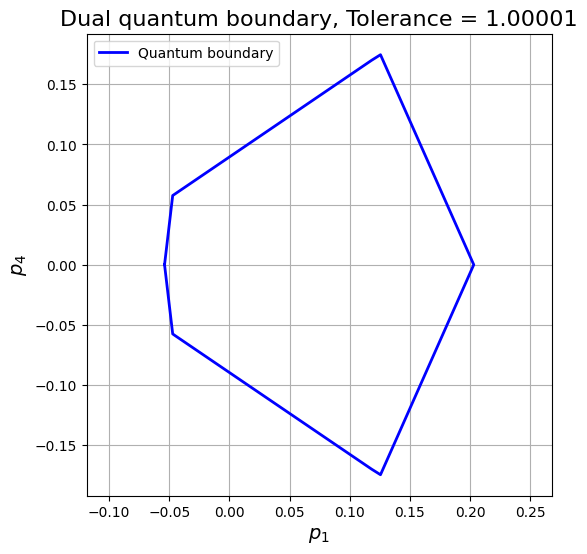

In [17]:
Theta_val = np.pi / 8 + np.pi/(64)
boundary = compute_boundary(Theta_val)

# Reflect the boundary across the p4-axis
reflected = boundary[boundary[:, 1] != 0] * np.array([1, -1])
full_boundary = np.vstack([boundary, reflected])

# Sort the points by polar angle to ensure a smooth curve
angles = np.arctan2(full_boundary[:, 1], full_boundary[:, 0])
sorted_idx = np.argsort(angles)
full_boundary = full_boundary[sorted_idx]

# Plotting
plt.figure(figsize=(6, 6))
plt.plot(full_boundary[:, 0], full_boundary[:, 1], 'b-', lw=2, label="Quantum boundary")
plt.xlabel(r"$p_1$", fontsize=14)
plt.ylabel(r"$p_4$", fontsize=14)
plt.title("Dual quantum boundary, Tolerance = 1.00001", fontsize=16)
plt.grid(True)
plt.axis("equal")
plt.legend()
plt.show()

## Mixed level 2 ($T_{ABB} = \mathcal{T}_{1+A+B+AB+AA'B}$)

In [49]:
# Define quantum operators
A_config = [2,2]
B_config = [2,2]

# Operators in problem
A = [Ai for Ai in ncp.generate_measurements(A_config, 'A')]
B = [Bj for Bj in ncp.generate_measurements(B_config, 'B')]

def get_extra_monomials():
    """
    Returns additional monomials to add to sdp relaxation.
    """

    monos = []

    Aflat = ncp.flatten(A)
    Bflat = ncp.flatten(B)

    # AAB
    for a in Aflat:
        for a2 in Aflat:
            for b in Bflat:
                monos += [a*a2*b]

    #AB
    for a in Aflat:
        for b in Bflat:
            monos += [a*b]
    
    
    return monos[:]

def get_subs():
    """
    Returns any substitution rules to use with ncpol2sdpa. E.g. projections and
    commutation relations.
    """
    subs = {}
    # Get Alice and Bob's projective measurement constraints
    subs.update(ncp.projective_measurement_constraints(A,B))

    return subs

subs = get_subs()             # substitutions used in ncpol2sdpa
moment_ineqs = []                      # moment inequalities
moment_eqs = []                        # moment equalities
op_eqs = []                            # operator equalities
op_ineqs = []                          # operator inequalities
extra_monos = get_extra_monomials()   # extra monomials

# Bounds on the parameters of sys
ops = ncp.flatten([A,B])        # Base monomials involved in problem

# Compute quantum value of Bell expression at (p1, p4) for a given Theta
def compute_beta(p1, p4, Theta):
    s = np.sqrt(2)

    beta_expr = 1/4*p4*(4*(-2 + 4*A[1][0]) - 8*s*(-1 + 2*A[1][0])*(-1 + B[0][0] + B[1][0])*np.cos(2*Theta) + 8*s*(-B[0][0] + B[1][0])*np.sin(2*Theta)) +  1/4*(4*s - 8*s*A[0][0] - 4*s*B[0][0] + 8*s*A[0][0]*B[0][0] - 4*s*B[1][0] + 8*s*A[0][0]*B[1][0] + s*(-1 + 2*A[1][0])*(B[0][0] - B[1][0])*1/np.tan(Theta) - s*(-1 + A[0][0])*(-1 + B[0][0] + B[1][0])*1/(np.sin(Theta))**2 - s*A[0][0]*(-1 + B[0][0] + B[1][0])*1/(np.cos(Theta))**2 + s*(-1 + 2*A[1][0])*(B[0][0] - B[1][0])*np.tan(Theta)) + 1/4*p1*(2*(-2 + s) + 8*A[0][0] - 2*s*B[0][0] - 2*s*B[1][0] - s*(-1 + 2*A[1][0])*(B[0][0] - B[1][0])*1/np.tan(Theta) + s*(-1 + A[0][0])*(-1 + B[0][0] + B[1][0])*1/(np.sin(Theta))**2 - s*A[0][0]*(-1 + B[0][0] + B[1][0])*1/(np.cos(Theta))**2 + s*(-1 + 2*A[1][0])*(B[0][0] - B[1][0])*np.tan(Theta))

    sdp = ncp.SdpRelaxation(ops, verbose=0, normalized=True, parallel=0)
    sdp.get_relaxation(
        level=2,
        equalities = op_eqs[:],
        inequalities = op_ineqs[:],
        momentequalities = moment_eqs[:],
        momentinequalities = moment_ineqs[:],
        objective=-beta_expr,
        substitutions = subs,
        extramonomials = extra_monos
    )
    sdp.solve(solver="mosek")
    return -sdp.dual

# Minimize r for fixed φ and Theta
def minimize_r(phi, Theta):
    def objective(r):
        if r < 0:
            return np.inf
        p1 = r * np.cos(phi)
        p4 = r * np.sin(phi)
        beta = compute_beta(p1, p4, Theta)
        return r if beta >= 1.00001 else np.inf

    res = minimize_scalar(objective, bounds=(0, 1), method='bounded')
    if res.success and np.isfinite(res.fun):
        r = res.x
        return r * np.cos(phi), r * np.sin(phi)
    else:
        return None

# Main routine
def compute_boundary(Theta, num_points=200, n_jobs=-1):
    phis = np.linspace(0, np.pi, num_points)
    boundary = Parallel(n_jobs=n_jobs)(
        delayed(minimize_r)(phi, Theta) for phi in phis
    )
    boundary = [pt for pt in boundary if pt is not None]
    return np.array(boundary)

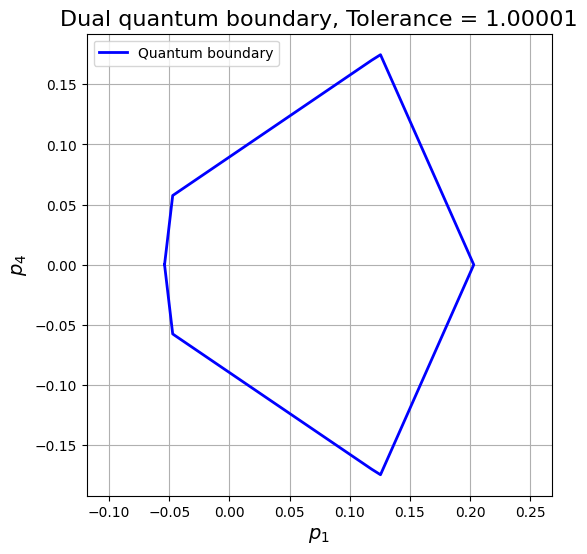

In [50]:
Theta_val = np.pi / 8 + np.pi/(64)
boundary = compute_boundary(Theta_val)

# Reflect the boundary across the p4-axis
reflected = boundary[boundary[:, 1] != 0] * np.array([1, -1])
full_boundary = np.vstack([boundary, reflected])

# Sort the points by polar angle to ensure a smooth curve
angles = np.arctan2(full_boundary[:, 1], full_boundary[:, 0])
sorted_idx = np.argsort(angles)
full_boundary = full_boundary[sorted_idx]

# Plotting
plt.figure(figsize=(6, 6))
plt.plot(full_boundary[:, 0], full_boundary[:, 1], 'b-', lw=2, label="Quantum boundary")
plt.xlabel(r"$p_1$", fontsize=14)
plt.ylabel(r"$p_4$", fontsize=14)
plt.title("Dual quantum boundary, Tolerance = 1.00001", fontsize=16)
plt.grid(True)
plt.axis("equal")
plt.legend()
plt.show()

## Mixed level 2 ($T_{ABB} = \mathcal{T}_{1+A+B+AB+ABB'+AA'B}$)

In [18]:
# Define quantum operators
A_config = [2,2]
B_config = [2,2]

# Operators in problem
A = [Ai for Ai in ncp.generate_measurements(A_config, 'A')]
B = [Bj for Bj in ncp.generate_measurements(B_config, 'B')]

def get_extra_monomials():
    """
    Returns additional monomials to add to sdp relaxation.
    """

    monos = []

    Aflat = ncp.flatten(A)
    Bflat = ncp.flatten(B)

    # ABB
    for a in Aflat:
        for b in Bflat:
            for b2 in Bflat:
                monos += [a*b*b2]
    # AAB
    for a in Aflat:
        for a2 in Aflat:
            for b in Bflat:
                monos += [a*a2*b]

    #AB
    for a in Aflat:
        for b in Bflat:
            monos += [a*b]
    
    
    return monos[:]

def get_subs():
    """
    Returns any substitution rules to use with ncpol2sdpa. E.g. projections and
    commutation relations.
    """
    subs = {}
    # Get Alice and Bob's projective measurement constraints
    subs.update(ncp.projective_measurement_constraints(A,B))

    return subs

subs = get_subs()             # substitutions used in ncpol2sdpa
moment_ineqs = []                      # moment inequalities
moment_eqs = []                        # moment equalities
op_eqs = []                            # operator equalities
op_ineqs = []                          # operator inequalities
extra_monos = get_extra_monomials()   # extra monomials

# Bounds on the parameters of sys
ops = ncp.flatten([A,B])        # Base monomials involved in problem

# Compute quantum value of Bell expression at (p1, p4) for a given Theta
def compute_beta(p1, p4, Theta):
    s = np.sqrt(2)

    beta_expr = 1/4*p4*(4*(-2 + 4*A[1][0]) - 8*s*(-1 + 2*A[1][0])*(-1 + B[0][0] + B[1][0])*np.cos(2*Theta) + 8*s*(-B[0][0] + B[1][0])*np.sin(2*Theta)) +  1/4*(4*s - 8*s*A[0][0] - 4*s*B[0][0] + 8*s*A[0][0]*B[0][0] - 4*s*B[1][0] + 8*s*A[0][0]*B[1][0] + s*(-1 + 2*A[1][0])*(B[0][0] - B[1][0])*1/np.tan(Theta) - s*(-1 + A[0][0])*(-1 + B[0][0] + B[1][0])*1/(np.sin(Theta))**2 - s*A[0][0]*(-1 + B[0][0] + B[1][0])*1/(np.cos(Theta))**2 + s*(-1 + 2*A[1][0])*(B[0][0] - B[1][0])*np.tan(Theta)) + 1/4*p1*(2*(-2 + s) + 8*A[0][0] - 2*s*B[0][0] - 2*s*B[1][0] - s*(-1 + 2*A[1][0])*(B[0][0] - B[1][0])*1/np.tan(Theta) + s*(-1 + A[0][0])*(-1 + B[0][0] + B[1][0])*1/(np.sin(Theta))**2 - s*A[0][0]*(-1 + B[0][0] + B[1][0])*1/(np.cos(Theta))**2 + s*(-1 + 2*A[1][0])*(B[0][0] - B[1][0])*np.tan(Theta))

    sdp = ncp.SdpRelaxation(ops, verbose=0, normalized=True, parallel=0)
    sdp.get_relaxation(
        level=2,
        equalities = op_eqs[:],
        inequalities = op_ineqs[:],
        momentequalities = moment_eqs[:],
        momentinequalities = moment_ineqs[:],
        objective=-beta_expr,
        substitutions = subs,
        extramonomials = extra_monos
    )
    sdp.solve(solver="mosek")
    return -sdp.dual

# Minimize r for fixed φ and Theta
def minimize_r(phi, Theta):
    def objective(r):
        if r < 0:
            return np.inf
        p1 = r * np.cos(phi)
        p4 = r * np.sin(phi)
        beta = compute_beta(p1, p4, Theta)
        return r if beta >= 1.00001 else np.inf

    res = minimize_scalar(objective, bounds=(0, 1), method='bounded')
    if res.success and np.isfinite(res.fun):
        r = res.x
        return r * np.cos(phi), r * np.sin(phi)
    else:
        return None

# Main routine
def compute_boundary(Theta, num_points=200, n_jobs=-1):
    phis = np.linspace(0, np.pi, num_points)
    boundary = Parallel(n_jobs=n_jobs)(
        delayed(minimize_r)(phi, Theta) for phi in phis
    )
    boundary = [pt for pt in boundary if pt is not None]
    return np.array(boundary)

### $\theta = \pi/4$

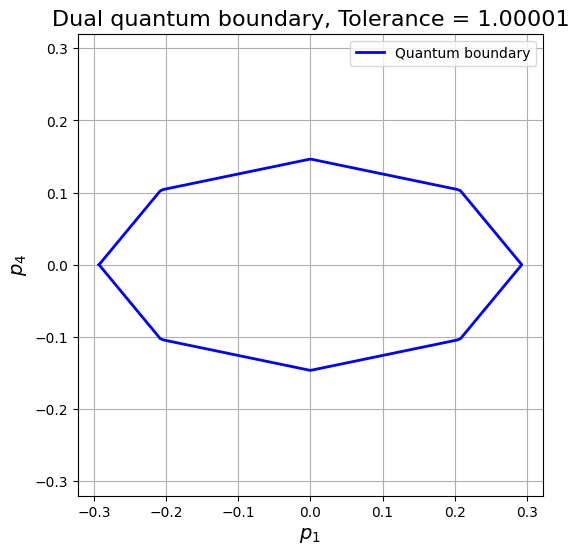

In [19]:
Theta_val = np.pi / 4
boundary = compute_boundary(Theta_val)

# Reflect the boundary across the p4-axis
reflected = boundary[boundary[:, 1] != 0] * np.array([1, -1])
full_boundary = np.vstack([boundary, reflected])

# Sort the points by polar angle to ensure a smooth curve
angles = np.arctan2(full_boundary[:, 1], full_boundary[:, 0])
sorted_idx = np.argsort(angles)
full_boundary = full_boundary[sorted_idx]

# Plotting
plt.figure(figsize=(6, 6))
plt.plot(full_boundary[:, 0], full_boundary[:, 1], 'b-', lw=2, label="Quantum boundary")
plt.xlabel(r"$p_1$", fontsize=14)
plt.ylabel(r"$p_4$", fontsize=14)
plt.title("Dual quantum boundary, Tolerance = 1.00001", fontsize=16)
plt.grid(True)
plt.axis("equal")
plt.legend()
plt.show()

### $\theta = \pi/8 + \pi/64$

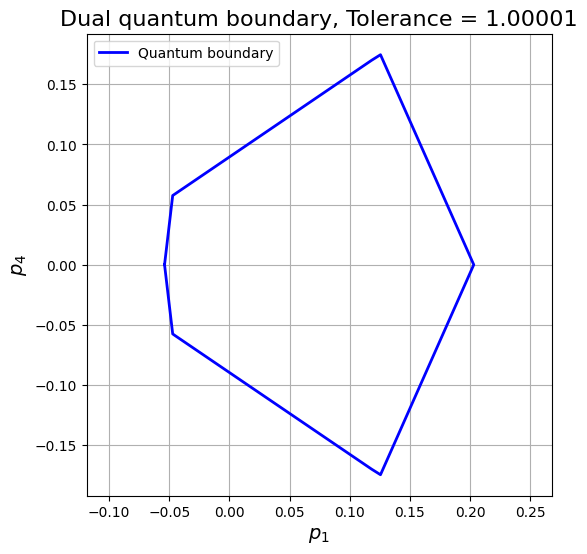

In [46]:
Theta_val = np.pi / 8 + np.pi/(64)
boundary = compute_boundary(Theta_val)

# Reflect the boundary across the p4-axis
reflected = boundary[boundary[:, 1] != 0] * np.array([1, -1])
full_boundary = np.vstack([boundary, reflected])

# Sort the points by polar angle to ensure a smooth curve
angles = np.arctan2(full_boundary[:, 1], full_boundary[:, 0])
sorted_idx = np.argsort(angles)
full_boundary = full_boundary[sorted_idx]

# Plotting
plt.figure(figsize=(6, 6))
plt.plot(full_boundary[:, 0], full_boundary[:, 1], 'b-', lw=2, label="Quantum boundary")
plt.xlabel(r"$p_1$", fontsize=14)
plt.ylabel(r"$p_4$", fontsize=14)
plt.title("Dual quantum boundary, Tolerance = 1.00001", fontsize=16)
plt.grid(True)
plt.axis("equal")
plt.legend()
plt.show()

# Quantum boundaries vs local polytopes (Mixed level 2 of the NPA hierarchy)

In [9]:
# Load the JSON file
with open("vertexCoords.json", "r") as f:
    data = json.load(f)

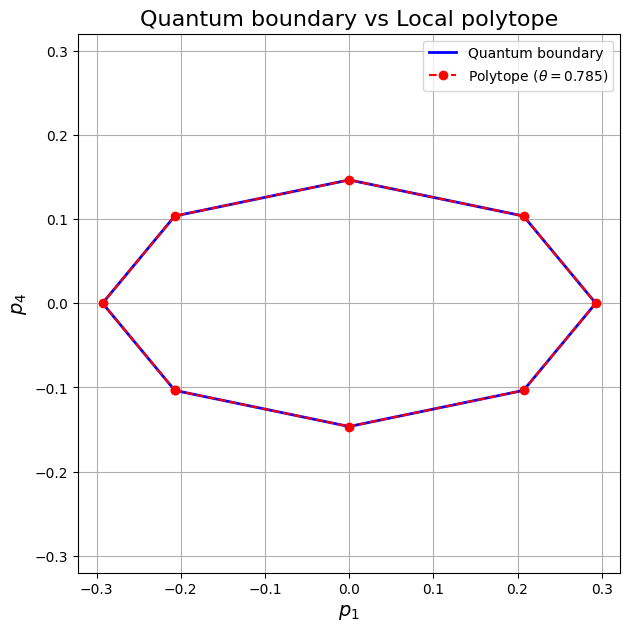

In [36]:
Theta_val = np.pi / 4
boundary = compute_boundary(Theta_val)

# Exploiting the p4 symmetry
reflected = boundary[boundary[:, 1] != 0].copy()
reflected[:, 1] *= -1
full_boundary = np.vstack([boundary, reflected])

# Ordering by angle
angles = np.arctan2(full_boundary[:, 1], full_boundary[:, 0])
sorted_idx = np.argsort(angles)
full_boundary = full_boundary[sorted_idx]
full_boundary = np.vstack([full_boundary, full_boundary[0]])  # close the boundary

# Plot
plt.figure(figsize=(7, 7))
plt.plot(full_boundary[:, 0], full_boundary[:, 1], 'b-', lw=2, label="Quantum boundary")

# Vertices of the local polytope obtained with Mathematica
tolerance = 1e-4
for theta_value, verts in data:
    if abs(theta_value - Theta_val) < tolerance:
        verts = np.array(verts)
        angles = np.arctan2(verts[:, 1], verts[:, 0])
        sorted_idx = np.argsort(angles)
        verts = verts[sorted_idx]
        verts = np.vstack([verts, verts[0]])  # close the polytope
        plt.plot(verts[:, 0], verts[:, 1], 'ro--', lw=1.5, label=fr"Polytope ($\theta = {Theta_val:.3f}$)")
        break

plt.xlabel(r"$p_1$", fontsize=14)
plt.ylabel(r"$p_4$", fontsize=14)
plt.title("Quantum boundary vs Local polytope", fontsize=16)
plt.grid(True)
plt.axis("equal")
plt.legend()
plt.show()

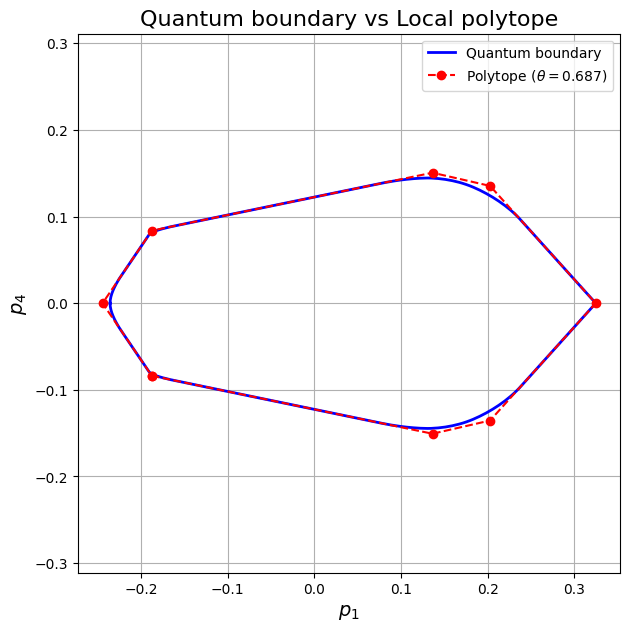

In [10]:
Theta_val = np.pi/4 - np.pi/32
boundary = compute_boundary(Theta_val)

# Exploiting the p4 symmetry
reflected = boundary[boundary[:, 1] != 0].copy()
reflected[:, 1] *= -1
full_boundary = np.vstack([boundary, reflected])

# Ordering by angle
angles = np.arctan2(full_boundary[:, 1], full_boundary[:, 0])
sorted_idx = np.argsort(angles)
full_boundary = full_boundary[sorted_idx]
full_boundary = np.vstack([full_boundary, full_boundary[0]])  # close the boundary

# Plot
plt.figure(figsize=(7, 7))
plt.plot(full_boundary[:, 0], full_boundary[:, 1], 'b-', lw=2, label="Quantum boundary")

# Vertices of the local polytope obtained with Mathematica
tolerance = 1e-4
for theta_value, verts in data:
    if abs(theta_value - Theta_val) < tolerance:
        verts = np.array(verts)
        angles = np.arctan2(verts[:, 1], verts[:, 0])
        sorted_idx = np.argsort(angles)
        verts = verts[sorted_idx]
        verts = np.vstack([verts, verts[0]])  # close the polytope
        plt.plot(verts[:, 0], verts[:, 1], 'ro--', lw=1.5, label=fr"Polytope ($\theta = {Theta_val:.3f}$)")
        break

plt.xlabel(r"$p_1$", fontsize=14)
plt.ylabel(r"$p_4$", fontsize=14)
plt.title("Quantum boundary vs Local polytope", fontsize=16)
plt.grid(True)
plt.axis("equal")
plt.legend()
plt.show()

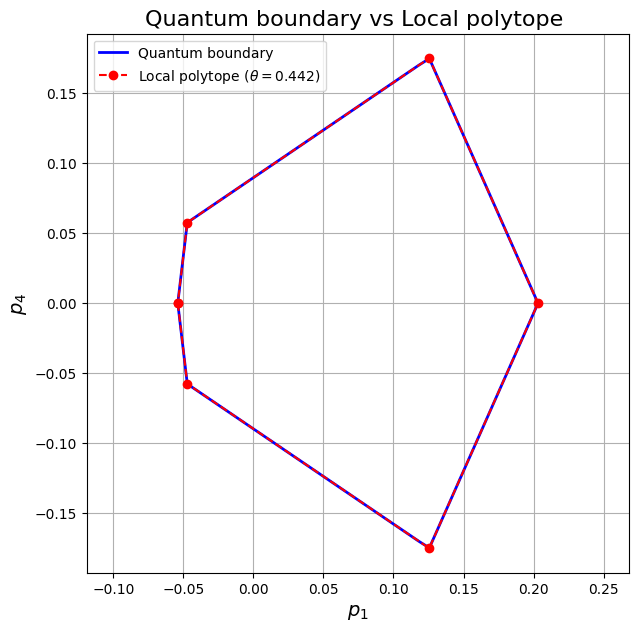

In [38]:
Theta_val = np.pi/8 + np.pi/64
boundary = compute_boundary(Theta_val)

# Exploiting the p4 symmetry
reflected = boundary[boundary[:, 1] != 0].copy()
reflected[:, 1] *= -1
full_boundary = np.vstack([boundary, reflected])

# Ordering by angle
angles = np.arctan2(full_boundary[:, 1], full_boundary[:, 0])
sorted_idx = np.argsort(angles)
full_boundary = full_boundary[sorted_idx]
full_boundary = np.vstack([full_boundary, full_boundary[0]])  # close the boundary

# Plot
plt.figure(figsize=(7, 7))
plt.plot(full_boundary[:, 0], full_boundary[:, 1], 'b-', lw=2, label="Quantum boundary")

# Vertices of the local polytope obtained with Mathematica
tolerance = 1e-4
for theta_value, verts in data:
    if abs(theta_value - Theta_val) < tolerance:
        verts = np.array(verts)
        angles = np.arctan2(verts[:, 1], verts[:, 0])
        sorted_idx = np.argsort(angles)
        verts = verts[sorted_idx]
        verts = np.vstack([verts, verts[0]])  # close the polytope
        plt.plot(verts[:, 0], verts[:, 1], 'ro--', lw=1.5, label=fr"Local polytope ($\theta = {Theta_val:.3f}$)")
        break

plt.xlabel(r"$p_1$", fontsize=14)
plt.ylabel(r"$p_4$", fontsize=14)
plt.title("Quantum boundary vs Local polytope ", fontsize=16)
plt.grid(True)
plt.axis("equal")
plt.legend()
plt.show()

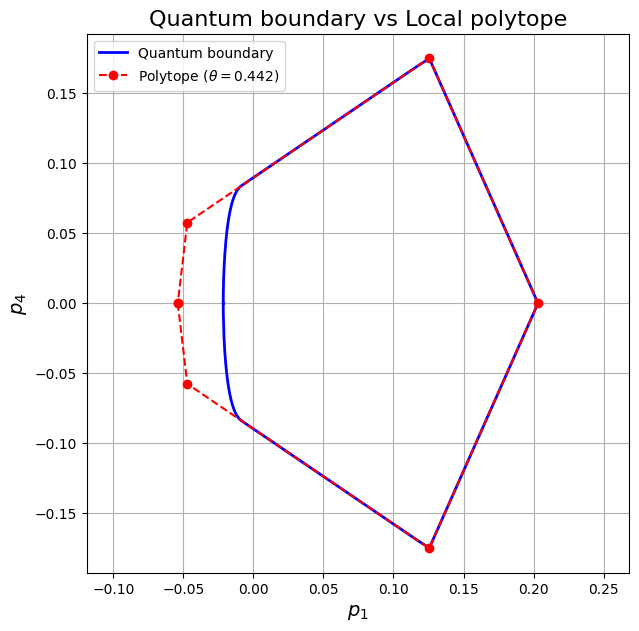

In [11]:
Theta_val = np.pi/8+ np.pi/64
boundary = compute_boundary(Theta_val)

# Exploiting the p4 symmetry
reflected = boundary[boundary[:, 1] != 0].copy()
reflected[:, 1] *= -1
full_boundary = np.vstack([boundary, reflected])

# Ordering by angle
angles = np.arctan2(full_boundary[:, 1], full_boundary[:, 0])
sorted_idx = np.argsort(angles)
full_boundary = full_boundary[sorted_idx]
full_boundary = np.vstack([full_boundary, full_boundary[0]])  # close the boundary

# Plot
plt.figure(figsize=(7, 7))
plt.plot(full_boundary[:, 0], full_boundary[:, 1], 'b-', lw=2, label="Quantum boundary")

# Vertices of the local polytope obtained with Mathematica
tolerance = 1e-4
for theta_value, verts in data:
    if abs(theta_value - Theta_val) < tolerance:
        verts = np.array(verts)
        angles = np.arctan2(verts[:, 1], verts[:, 0])
        sorted_idx = np.argsort(angles)
        verts = verts[sorted_idx]
        verts = np.vstack([verts, verts[0]])  # close the polytope
        plt.plot(verts[:, 0], verts[:, 1], 'ro--', lw=1.5, label=fr"Polytope ($\theta = {Theta_val:.3f}$)")
        break

plt.xlabel(r"$p_1$", fontsize=14)
plt.ylabel(r"$p_4$", fontsize=14)
plt.title("Quantum boundary vs Local polytope", fontsize=16)
plt.grid(True)
plt.axis("equal")
plt.legend()
plt.show()

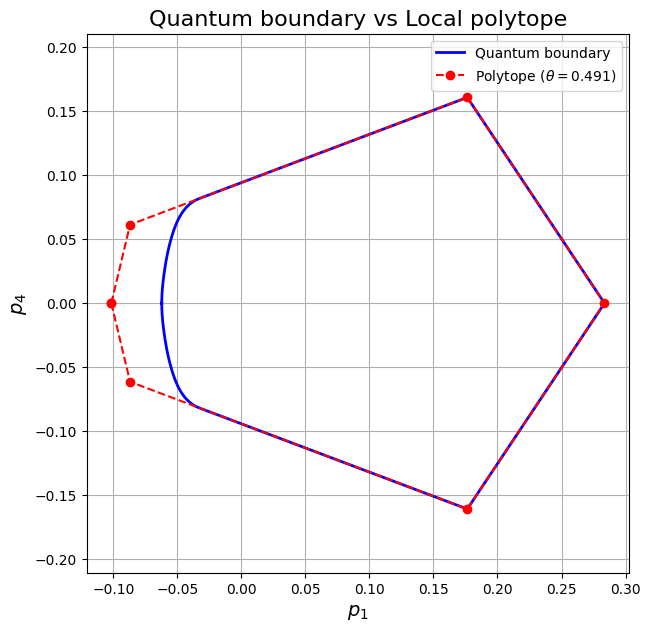

In [12]:
Theta_val = np.pi/8 + np.pi/32
boundary = compute_boundary(Theta_val)

# Exploiting the p4 symmetry
reflected = boundary[boundary[:, 1] != 0].copy()
reflected[:, 1] *= -1
full_boundary = np.vstack([boundary, reflected])

# Ordering by angle
angles = np.arctan2(full_boundary[:, 1], full_boundary[:, 0])
sorted_idx = np.argsort(angles)
full_boundary = full_boundary[sorted_idx]
full_boundary = np.vstack([full_boundary, full_boundary[0]])  # close the boundary

# Plot
plt.figure(figsize=(7, 7))
plt.plot(full_boundary[:, 0], full_boundary[:, 1], 'b-', lw=2, label="Quantum boundary")

# Vertices of the local polytope obtained with Mathematica
tolerance = 1e-4
for theta_value, verts in data:
    if abs(theta_value - Theta_val) < tolerance:
        verts = np.array(verts)
        angles = np.arctan2(verts[:, 1], verts[:, 0])
        sorted_idx = np.argsort(angles)
        verts = verts[sorted_idx]
        verts = np.vstack([verts, verts[0]])  # close the polytope
        plt.plot(verts[:, 0], verts[:, 1], 'ro--', lw=1.5, label=fr"Polytope ($\theta = {Theta_val:.3f}$)")
        break

plt.xlabel(r"$p_1$", fontsize=14)
plt.ylabel(r"$p_4$", fontsize=14)
plt.title("Quantum boundary vs Local polytope", fontsize=16)
plt.grid(True)
plt.axis("equal")
plt.legend()
plt.show()